In [1]:
"""Explore the behaviour of optimal solution of linear masked autoencoder for multiple samples."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Note prob is the un-masked probability
"""
def binary_mat_generator(prob, m, n):
    num0 = int(n*prob) # num1 of entries is 1 in every row
    num1 = n - num0
    vec = np.concatenate([np.zeros(num0), np.ones(num1)])
    mat = np.tile(vec, (m, 1))
    idx = np.random.rand(*mat.shape).argsort(axis=1)
    mat_shuffle = np.take_along_axis(mat, idx, axis=1)
    return torch.tensor(mat_shuffle).float()
"""
    
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob_list)

def mask_patches(prob, patch_size, sample_num, sample_dim):
    patch_size = torch.tensor(patch_size)
    sample_dim = torch.tensor(sample_dim)
    feature_num = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, feature_num)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")


In [3]:
# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, sample_num, sample_dim, type='basic', patch_size=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        self.m = sample_num
        self.sample_dim = sample_dim
        self.H, self.W = sample_dim
        self.n = self.H * self.W
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.n, bias=False)
        w2 = nn.Linear(self.n, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, self.m, self.n)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, self.m, self.n)
            elif self.masking_type == 'patches':
                mask = mask_patches(self.prob, self.patch_size, self.m, self.sample_dim)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [5]:
prob = 0.5
sample_num = 100
H = 4
W = 4
sample_dim = [H, W]
m = sample_num
n = H * W

inputs = torch.rand(m, n) * 2
targets = inputs

In [8]:
m_net = M_LAE(prob, sample_num, sample_dim, type='basic')

learning_rate = 0.0001
epochs = 10000
counter = 2000
criterion = nn.MSELoss()
optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)

In [9]:
"""
# version 1
loss_plt = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = m_net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    loss_plt.append(loss.item())
    if epoch % counter == 0:
        print('epoch: ', epoch, 'loss: ', loss.item())
    if epoch == 6000:
        learning_rate /= 3
        optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)
"""

# version 2
N = 30
loss_plt = []
for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    #N = torch.randint(20, 60, (1,))[0]
    for i in range(N):
        outputs = m_net(inputs)
        loss = criterion(outputs, targets)
        loss_total += loss
    loss_total /= N
    loss_total.backward()
    optimizer.step()
    loss_plt.append(loss_total.item())
    if epoch % counter == 0:
        print('epoch: ', epoch, 'loss: ', loss_total.item())
    if epoch % 10000 == 0:
        learning_rate /= 4
        optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)

epoch:  0 loss:  1.444421410560608
epoch:  2000 loss:  0.6345778703689575
epoch:  4000 loss:  0.4209226369857788
epoch:  6000 loss:  0.38404273986816406
epoch:  8000 loss:  0.3648962676525116


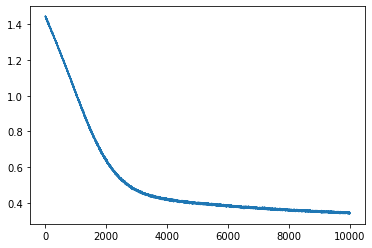

In [10]:
plt.plot(loss_plt)

In [11]:
params = list(m_net.body.parameters())

In [12]:
W1 = params[0].requires_grad_(False)
W2 = params[1].requires_grad_(False)

In [13]:
N = 1000
gradient1 = 0
gradient2 = 0
X = inputs
for i in range(N):
    Y = torch.mul(mask_basic(prob, m, n), X)
    gradient1 += W2.T @ (W2@W1@Y.T-X.T) @ Y
    gradient2 += (W2@W1@Y.T-X.T) @ Y @ W1.T
print(gradient1 / N)
print(gradient1 / N)

tensor([[-4.8683e-03, -1.3682e-01,  7.2729e-01,  1.5095e+00,  8.8139e-01,
         -9.9802e-02, -2.1892e+00,  2.2251e-01,  6.2661e-01, -2.9464e-01,
          8.1962e-01,  1.1299e+00, -3.4293e+00,  1.2465e-01,  1.9142e-01,
         -1.8168e+00],
        [-6.2014e-02, -1.1009e+00, -4.5098e-02,  6.3619e-02,  7.1414e-01,
          5.8975e-02,  9.6733e-02,  2.8147e-01,  3.1999e-01, -1.9500e-01,
          9.5180e-01,  1.4379e-02, -3.7625e-01, -3.2970e-01,  1.2974e+00,
         -8.3017e-01],
        [ 2.6770e-01,  8.4235e-02, -7.4019e-01, -1.6048e-01, -7.6319e-01,
          6.0641e-02,  2.8961e-01,  5.3797e-02,  2.3715e-01, -1.4802e+00,
         -1.0262e+00,  1.7175e+00,  1.2430e+00,  7.1704e-01, -3.6758e-01,
          8.8358e-01],
        [-4.0761e-01, -8.0475e-01,  1.0733e+00, -5.9675e-02, -3.4109e-02,
         -4.1519e-01,  2.4235e-01,  7.0293e-01, -6.8010e-03, -4.1854e-01,
          7.9474e-01,  1.9462e-01,  1.4752e+00, -1.5892e+00, -2.0163e-02,
          4.2631e-01],
        [-5.6079e-01

In [14]:
X = inputs
mean_m = torch.ones(m, n) * prob
square_m = torch.ones(n, n) * prob**2
square_m.fill_diagonal_(prob)
W2.T @ (W2@W1@(square_m*(X.T@X)) - X.T@(mean_m*X))

tensor([[ 0.0491, -0.1111,  0.7212,  1.4889,  1.0329, -0.1685, -2.1776,  0.2243,
          0.6612, -0.2318,  0.7131,  1.0885, -3.3981,  0.1797,  0.2573, -1.8114],
        [-0.1759, -1.1893, -0.1443,  0.0647,  0.6414,  0.2083, -0.1261,  0.2373,
          0.2378, -0.0301,  0.8584,  0.1689, -0.4618, -0.3049,  1.1686, -0.8732],
        [ 0.2493, -0.0460, -0.8605, -0.1979, -0.8668,  0.1789,  0.1044, -0.0629,
          0.1579, -1.3643, -1.1280,  1.7117,  1.2050,  0.7727, -0.5688,  0.8624],
        [-0.4746, -0.9336,  0.8928, -0.1072, -0.2170, -0.2175,  0.0361,  0.6338,
         -0.0402, -0.2297,  0.6304,  0.2203,  1.4917, -1.5939, -0.1625,  0.4649],
        [-0.4445,  1.0080, -0.0720,  0.0641, -1.3335,  0.5171,  1.1722,  1.0239,
          0.3142, -0.9528,  0.2927,  0.0386, -1.5566,  0.0110, -1.5598,  0.0128],
        [-0.0088,  0.1903,  0.1479,  0.8990, -0.1706,  0.6708, -1.8056, -2.4334,
          0.2589,  1.0180,  0.3483, -0.6913, -1.2794,  0.9665, -0.4914,  0.1569],
        [ 1.4931, -0.7